# Ace dataset Querying

----

In [134]:
import pandas as pd # data wrangler library, dataframes are used to display and manipulate data
import seaborn as sns # data graphing library, built on top of matplotlib
import matplotlib.pyplot as plt # graphing library, used for titles and customization
import urllib.parse # library to parse URLs for querying

## Pre Work

First we wil get the API's for datasets we want to query.

In [135]:
routes_api = "https://data.ny.gov/resource/ki2b-sg5y.csv"
ace_violations_api = "https://data.ny.gov/resource/kh8p-hcbm.csv"

## Route Fetching

Using the routes_api we will get the buses who are in the ACE system and when they started service.

In [136]:
# Getting data

ace_start_df = pd.read_csv(routes_api)
ace_start_df.head()

,route,program,implementation_date
0,M15+,ABLE,2019-10-07T00:00:00.000
1,B44+,ABLE,2019-10-30T00:00:00.000
2,M14+,ABLE,2019-11-21T00:00:00.000
3,B46+,ABLE,2020-02-19T00:00:00.000
4,M23+,ABLE,2020-08-10T00:00:00.000


In [137]:
# Selecting only ace buses

ace_start_df = ace_start_df[ace_start_df['program'] == 'ACE']
ace_start_df.head()

,route,program,implementation_date
21,M15+,ACE,2024-06-20T00:00:00.000
22,B44+,ACE,2024-06-20T00:00:00.000
23,M14+,ACE,2024-06-20T00:00:00.000
24,B46+,ACE,2024-06-20T00:00:00.000
25,M23+,ACE,2024-06-20T00:00:00.000


In [138]:
# Converting implementation_date to datetime format

ace_start_df['implementation_date'] = pd.to_datetime(ace_start_df['implementation_date'])
ace_start_df.head()

,route,program,implementation_date
21,M15+,ACE,2024-06-20
22,B44+,ACE,2024-06-20
23,M14+,ACE,2024-06-20
24,B46+,ACE,2024-06-20
25,M23+,ACE,2024-06-20


In [139]:
# Sorting by route

ace_start_df.sort_values(by='route', inplace=True)
ace_start_df.reset_index(drop=True, inplace=True)
ace_start_df.head()

,route,program,implementation_date
0,B25,ACE,2024-09-30
1,B26,ACE,2024-09-30
2,B35,ACE,2024-09-16
3,B41,ACE,2024-09-16
4,B42,ACE,2024-09-16


In [140]:
# creating function to set borough based on route prefix

def set_borough(x):
    if x.startswith('BX'):
        return 'Bronx'
    elif x.startswith('Q'):
        return 'Queens'
    elif x.startswith('M'):
        return 'Manhattan'
    elif x.startswith('S'):
        return 'Staten Island'
    elif x.startswith('B'):
        return 'Brooklyn'
    else:
        return 'Unknown'

In [141]:
# apply() is used to apply a function along a dataframe, in this case we used our function set_borough

ace_start_df['Borough'] = ace_start_df['route'].apply(set_borough)
ace_start_df.head()

,route,program,implementation_date,Borough
0,B25,ACE,2024-09-30,Brooklyn
1,B26,ACE,2024-09-30,Brooklyn
2,B35,ACE,2024-09-16,Brooklyn
3,B41,ACE,2024-09-16,Brooklyn
4,B42,ACE,2024-09-16,Brooklyn


## Soql Setup

Inorder to read our query, our Api link uses soql, to automate the process we make a function to encode our query

In [142]:
def encode_soql_query(query:str) -> str:
    # just in case there are any new lines in the query, replaces them with spaces
    while '\n' in query:
        query = query.replace('\n', ' ')
    
    # encodes the query to be URL friendly
    parsed_query = urllib.parse.quote(query)
    
    # return query with prefix needed for soql queries
    return '?$query=' + parsed_query

## Ace Violations Dataset

Now we will query through the ACE violations dataset

### Calculate amount of unique violations by status

In [145]:
unique_violation_status_query = """
select violation_status, count(violation_status) as amount_of_violations
group by violation_status
order by amount_of_violations DESC
"""

encoded_query = encode_soql_query(unique_violation_status_query)

In [146]:
api_query = ace_violations_api + encoded_query
unique_violations = pd.read_csv(api_query)
unique_violations.head(15)

,violation_status,amount_of_violations
0,VIOLATION ISSUED,2312878
1,TECHNICAL ISSUE/OTHER,320912
2,EXEMPT - EMERGENCY VEHICLE,286253
3,DRIVER/VEHICLE INFO MISSING,273968
4,EXEMPT - COMMERCIAL UNDER 20,257374
5,EXEMPT - BUS/PARATRANSIT,190192
6,EXEMPT - OTHER,136991


In [147]:
unique_violations['percentage'] = (unique_violations['amount_of_violations'] / unique_violations['amount_of_violations'].sum()) * 100
unique_violations.head(15)

,violation_status,amount_of_violations,percentage
0,VIOLATION ISSUED,2312878,61.210437
1,TECHNICAL ISSUE/OTHER,320912,8.492953
2,EXEMPT - EMERGENCY VEHICLE,286253,7.575701
3,DRIVER/VEHICLE INFO MISSING,273968,7.250577
4,EXEMPT - COMMERCIAL UNDER 20,257374,6.811416
5,EXEMPT - BUS/PARATRANSIT,190192,5.033441
6,EXEMPT - OTHER,136991,3.625474


In [148]:
sns.set_theme(style="darkgrid")


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'VIOLATION ISSUED'),
  Text(1, 0, 'TECHNICAL ISSUE/OTHER'),
  Text(2, 0, 'EXEMPT - EMERGENCY VEHICLE'),
  Text(3, 0, 'DRIVER/VEHICLE INFO MISSING'),
  Text(4, 0, 'EXEMPT - COMMERCIAL UNDER 20'),
  Text(5, 0, 'EXEMPT - BUS/PARATRANSIT'),
  Text(6, 0, 'EXEMPT - OTHER')])

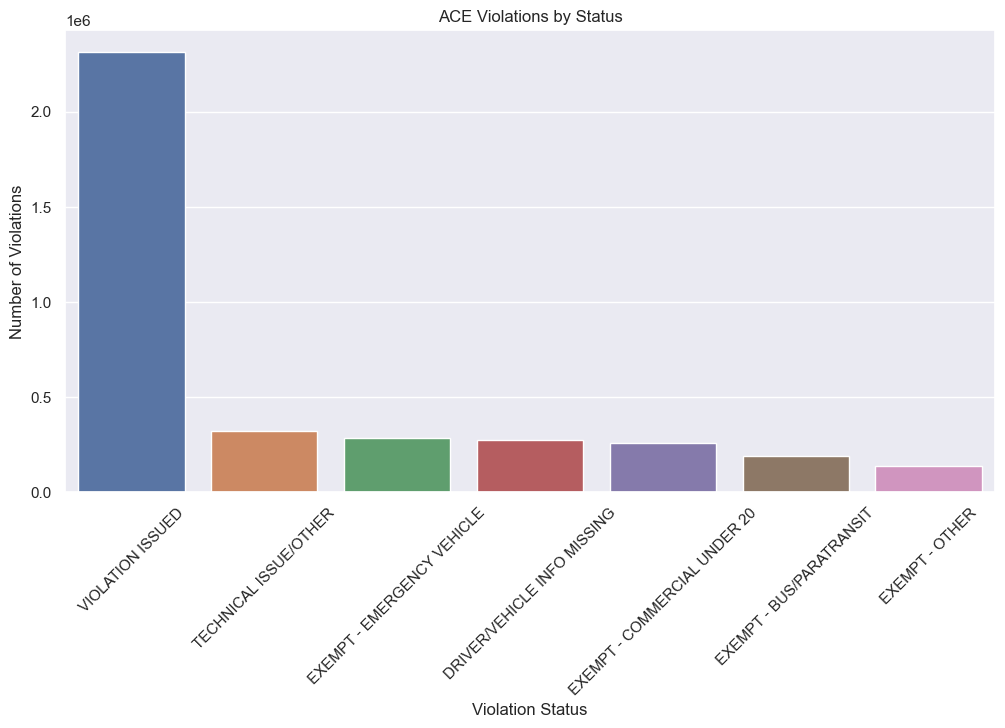

In [149]:
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_violations, x='violation_status', y='amount_of_violations', hue='violation_status')
plt.title('ACE Violations by Status')
plt.xlabel('Violation Status')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)

### Count violations by Bus/Borough

Now we will count how many violations each bus/borough has

In [159]:
violations_bus_query = """
select
bus_route_id,
count(violation_status) as amount_of_violations
where bus_route_id is not null
group by bus_route_id
order by bus_route_id, amount_of_violations DESC
"""

encoded_query = encode_soql_query(violations_bus_query)
api_query = ace_violations_api + encoded_query

In [160]:
violations_by_bus = pd.read_csv(api_query)
violations_by_bus.head(15)

,bus_route_id,amount_of_violations
0,B25,44304
1,B26,20656
2,B35,106526
3,B41,94151
4,B42,10600
5,B44+,171083
6,B46+,186192
7,B62,26612
8,B82+,106426
9,BX12+,185059


In [161]:
violations_by_bus['borough'] = violations_by_bus['bus_route_id'].apply(set_borough)
violations_by_bus.head(15)

,bus_route_id,amount_of_violations,borough
0,B25,44304,Brooklyn
1,B26,20656,Brooklyn
2,B35,106526,Brooklyn
3,B41,94151,Brooklyn
4,B42,10600,Brooklyn
5,B44+,171083,Brooklyn
6,B46+,186192,Brooklyn
7,B62,26612,Brooklyn
8,B82+,106426,Brooklyn
9,BX12+,185059,Bronx


In [162]:
violations_by_borough = violations_by_bus.groupby('borough').agg({'amount_of_violations':'sum'}).reset_index()
violations_by_borough = violations_by_borough.sort_values(by='amount_of_violations', ascending=False)
violations_by_borough.head()

,borough,amount_of_violations
0,Bronx,1269364
2,Manhattan,1184075
1,Brooklyn,766550
3,Queens,484890
4,Staten Island,62940


In [163]:
violations_by_borough['amount_of_violations_percentage'] = (violations_by_borough['amount_of_violations'] / violations_by_borough['amount_of_violations'].sum()) * 100
violations_by_borough.head()

,borough,amount_of_violations,amount_of_violations_percentage
0,Bronx,1269364,33.689623
2,Manhattan,1184075,31.426005
1,Brooklyn,766550,20.344661
3,Queens,484890,12.869249
4,Staten Island,62940,1.670462


Text(0, 0.5, 'Number of Violations')

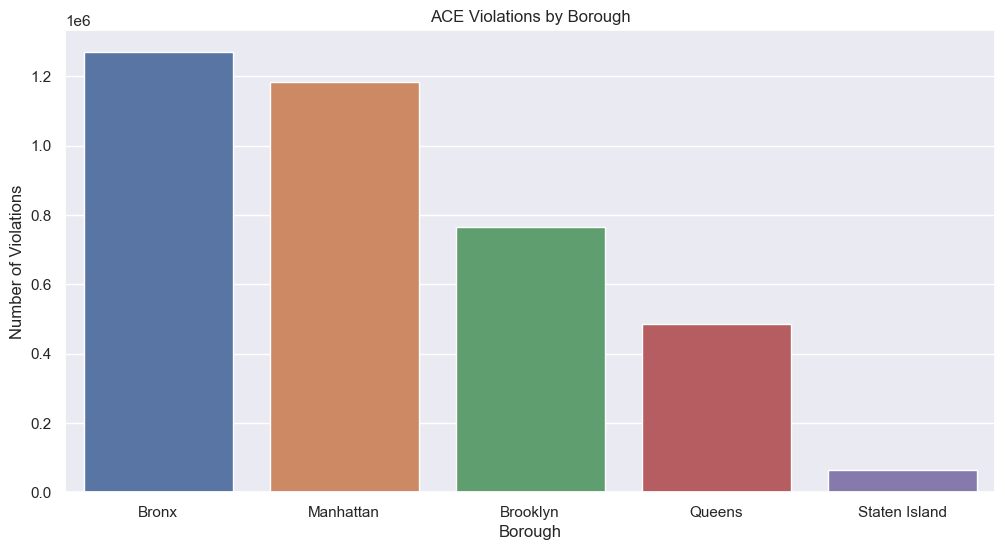

In [164]:
plt.figure(figsize=(12, 6))
sns.barplot(data=violations_by_borough, x='borough', y='amount_of_violations', hue='borough')
plt.title('ACE Violations by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Violations')

In [165]:
most_violated_routes_query = """
select
bus_route_id,
count(bus_route_id) as amount_of_violations
group by bus_route_id
order by amount_of_violations DESC, Last Occurrence DESC
limit 25
"""

encoded_query = encode_soql_query(most_violated_routes_query)
api_query = ace_violations_api + encoded_query

In [166]:
mv_routes_df = pd.read_csv(api_query)
mv_routes_df.head()

HTTPError: HTTP Error 400: Bad Request

<Axes: xlabel='bus_route_id', ylabel='amount_of_violations'>

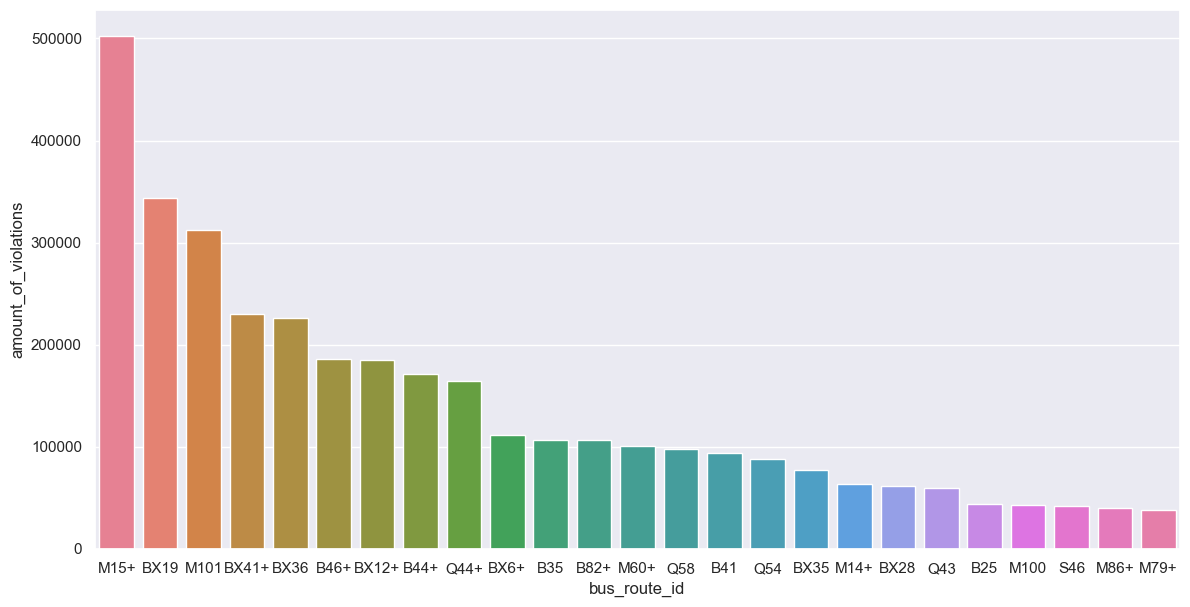

In [167]:
plt.figure(figsize=(14, 7))
sns.barplot(data=mv_routes_df, x='bus_route_id', y='amount_of_violations', hue='bus_route_id')

In [ ]:
violation_types_query = """
select bus_route_id, violation_type, count(violation_type) as amount_of_violations
where bus_route_id in ('M15+', 'BX19', 'M101', 'BX41+', 'BX36')
group by bus_route_id, violation_type
order by amount_of_violations desc, Last Occurrence DESC
"""

encoded_query = encode_soql_query(violation_types_query)
api_query = ace_violations_api + encoded_query

In [ ]:
violation_types_df = pd.read_csv(api_query)
violation_types_df.head()

,bus_route_id,violation_type,amount_of_violations
0,M15+,MOBILE BUS LANE,360276
1,M101,MOBILE DOUBLE PARKED,140666
2,M101,MOBILE BUS STOP,124944
3,B46+,MOBILE BUS LANE,110614
4,M15+,MOBILE BUS STOP,110034


In [ ]:
violation_types_df[violation_types_df['bus_route_id'] == 'M15+']

,bus_route_id,violation_type,amount_of_violations
0,M15+,MOBILE BUS LANE,360276
4,M15+,MOBILE BUS STOP,110034
7,M15+,MOBILE DOUBLE PARKED,32455


In [ ]:
violation_status_query = """
select bus_route_id, violation_status, count(violation_status) as amount_of_violations
where bus_route_id in ('M15+', 'M101', 'B25', 'B46+', 'Q53+')
group by bus_route_id, violation_status
order by bus_route_id asc
"""

encoded_query = encode_soql_query(violation_status_query)
api_query = ace_violations_api + encoded_query

In [ ]:
violation_status_df = pd.read_csv(api_query)
violation_status_df.head()

,bus_route_id,violation_status,amount_of_violations
0,B25,DRIVER/VEHICLE INFO MISSING,2427
1,B25,EXEMPT - BUS/PARATRANSIT,1314
2,B25,EXEMPT - COMMERCIAL UNDER 20,2306
3,B25,EXEMPT - EMERGENCY VEHICLE,2047
4,B25,EXEMPT - OTHER,3252


In [ ]:
violation_status_df[violation_status_df['bus_route_id'] == 'M15+']

,bus_route_id,violation_status,amount_of_violations
21,M15+,DRIVER/VEHICLE INFO MISSING,26492
22,M15+,EXEMPT - BUS/PARATRANSIT,48340
23,M15+,EXEMPT - COMMERCIAL UNDER 20,15480
24,M15+,EXEMPT - EMERGENCY VEHICLE,76585
25,M15+,EXEMPT - OTHER,27711
26,M15+,TECHNICAL ISSUE/OTHER,49667
27,M15+,VIOLATION ISSUED,258490
